In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
project_path = "/content/drive/MyDrive/BankMarketingProject/"
data_path = project_path + "data/raw/bank.csv"


In [31]:
import pandas as pd
df = pd.read_csv(data_path, sep=";")

print(df.shape)
df.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [32]:
print(df.info())
print(df.describe(include="all").T)
print("Target distribution:\n", df['y'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None
            count unique         top  freq         mean          std     min  \
age        452

In [33]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})


In [34]:
import numpy as np

# Contacted before feature from pdays
df['contacted_before'] = (df['pdays'] != -1).astype(int)

# Replace -1 with median in pdays
df['pdays_imputed'] = df['pdays'].replace(-1, np.nan)
df['pdays_imputed'] = df['pdays_imputed'].fillna(df['pdays_imputed'].median())

# Clip and log-transform balance (optional)
low, high = df['balance'].quantile([0.01, 0.99])
df['balance_clipped'] = df['balance'].clip(low, high)
df['balance_log'] = np.log1p(df['balance_clipped'] - df['balance_clipped'].min() + 1)


In [35]:
X = df.drop(columns=['y'])
y = df['y']

# Split categorical and numeric
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)


Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'contacted_before', 'pdays_imputed', 'balance_clipped', 'balance_log']


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [37]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), numeric_cols),
#         ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output==False), categorical_cols),
#     ],
#     remainder="drop"
# )


In [38]:
import sklearn
print(sklearn.__version__)


1.6.1


In [39]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), numeric_cols),
#         ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),  # if sklearn < 1.2
#         # ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),  # if sklearn >= 1.2
#     ],
#     remainder="drop"
# )


In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"
)


In [41]:
from imblearn.over_sampling import SMOTE

# Transform train features first
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_trans, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: y
0    3199
1     417
Name: count, dtype: int64
After SMOTE: y
0    3199
1    3199
Name: count, dtype: int64


Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_res, y_train_res)


LogisticRegression(max_iter=1000)

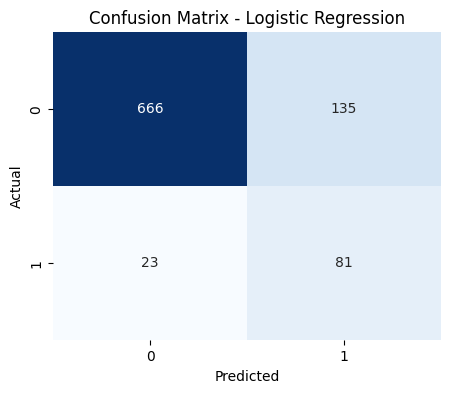

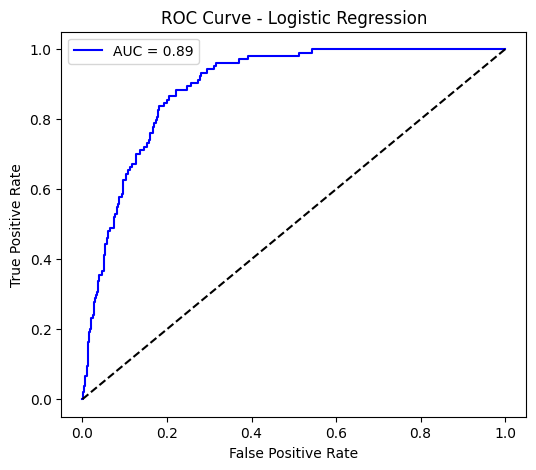

Logistic Regression Accuracy: 0.825414364640884


In [43]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

# Predictions
y_pred_log = log_reg.predict(X_test_trans)
y_proba_log = log_reg.predict_proba(X_test_trans)[:,1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="blue")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))


Support Vector Machine (SVM)

In [44]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train_res, y_train_res)


SVC(C=1, probability=True)

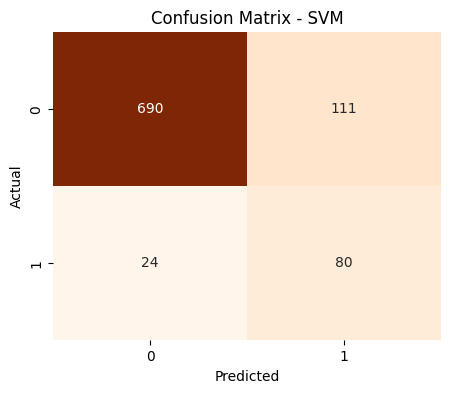

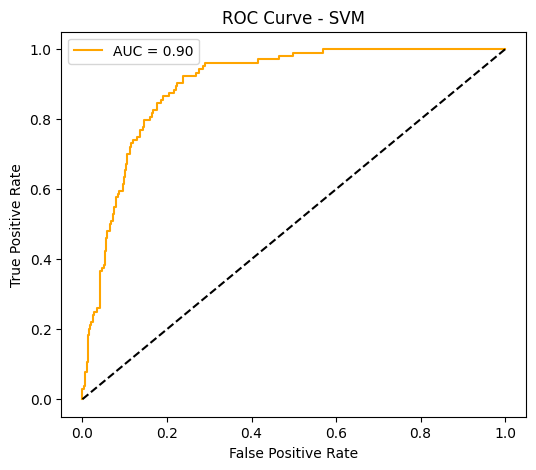

SVM Accuracy: 0.850828729281768


In [45]:
# Predictions
y_pred_svm = svm.predict(X_test_trans)
y_proba_svm = svm.predict_proba(X_test_trans)[:,1]  # since probability=True

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="orange")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.show()

# Accuracy
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)


RandomForestClassifier(random_state=42)

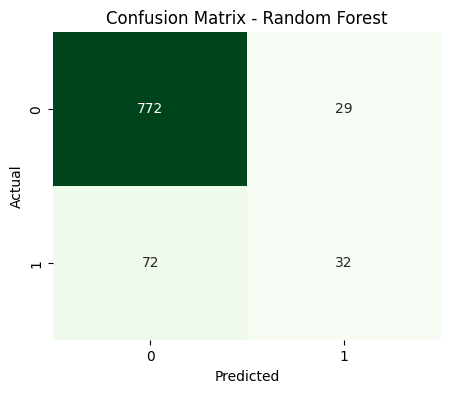

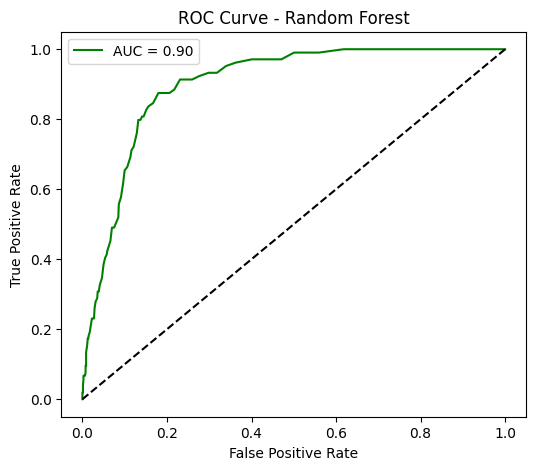

Random Forest Accuracy: 0.8883977900552487


In [47]:
# Predictions
y_pred_rf = rf.predict(X_test_trans)
y_proba_rf = rf.predict_proba(X_test_trans)[:,1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="green")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


In [48]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

for name, model in [("Logistic Regression", log_reg), ("SVM", svm), ("Random Forest", rf)]:
    y_pred = model.predict(X_test_trans)
    y_proba = model.predict_proba(X_test_trans)[:,1] if hasattr(model, "predict_proba") else None

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))



Logistic Regression
Accuracy: 0.825414364640884
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       801
           1       0.38      0.78      0.51       104

    accuracy                           0.83       905
   macro avg       0.67      0.81      0.70       905
weighted avg       0.90      0.83      0.85       905

ROC-AUC: 0.8941467396523576

SVM
Accuracy: 0.850828729281768
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       801
           1       0.42      0.77      0.54       104

    accuracy                           0.85       905
   macro avg       0.69      0.82      0.73       905
weighted avg       0.90      0.85      0.87       905

ROC-AUC: 0.9000648228176318

Random Forest
Accuracy: 0.8883977900552487
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       801
           1       0.52      0.31      0.39       104



,Recall Score
Logistic,0.7788
SVC,0.7692
RF,0.3077


/tmp/ipython-input-2749330023.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Recall Score"], palette="Blues_d")


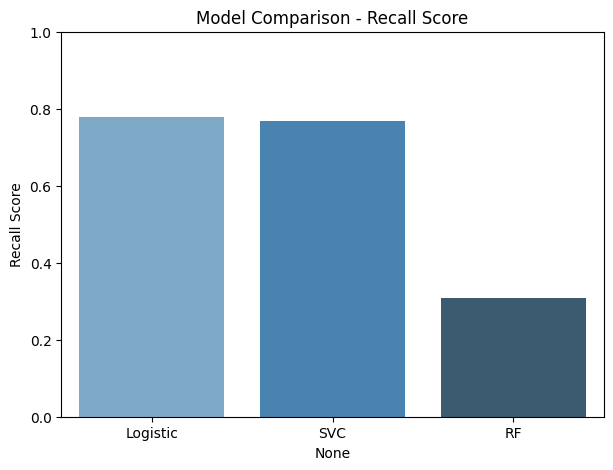

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Dictionary to store recall scores
recall_scores = {}

for name, model in [
    ("Logistic", log_reg),
    ("SVC", svm),
    ("RF", rf),
]:
    y_pred = model.predict(X_test_trans)
    recall_scores[name] = recall_score(y_test, y_pred)

# Convert to DataFrame
results_df = pd.DataFrame.from_dict(recall_scores, orient='index', columns=["Recall Score"])
results_df = results_df.sort_values(by="Recall Score", ascending=False)

# Display as styled table (like your screenshot)
display(results_df.style.background_gradient(cmap="Blues").format("{:.4f}"))

# Barplot for visualization
plt.figure(figsize=(7,5))
sns.barplot(x=results_df.index, y=results_df["Recall Score"], palette="Blues_d")
plt.title("Model Comparison - Recall Score")
plt.ylabel("Recall Score")
plt.ylim(0,1)
plt.show()
